In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras
from sklearn.preprocessing import StandardScaler, PowerTransformer, MaxAbsScaler, Normalizer, RobustScaler, minmax_scale, QuantileTransformer

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('../input/historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [3]:
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [4]:
trainSet.head()

,ticker,open,close,adj_close,low,high,volume
date,,,,,,,
2015-01-02,A,41.180000,40.560001,39.161114,40.369999,41.310001,1529200
2015-01-05,A,40.320000,39.799999,38.427319,39.700001,40.459999,2041800
2015-01-06,A,39.810001,39.180000,37.828701,39.020000,40.020000,2080600
2015-01-07,A,39.520000,39.700001,38.330769,39.290001,39.810001,3359700
2015-01-08,A,40.240002,40.889999,39.479725,40.180000,40.980000,2116300


In [5]:
symbols = trainSet.ticker.unique()

In [6]:
symbols[:100]

array(['A', 'AA', 'AABA', 'AAL', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP',
       'AAPL', 'AAT', 'AAV', 'AAWW', 'AAXJ', 'AAXN', 'AB', 'ABAC', 'ABAX',
       'ABB', 'ABBV', 'ABC', 'ABCB', 'ABCD', 'ABDC', 'ABEO', 'ABEV',
       'ABG', 'ABIL', 'ABIO', 'ABM', 'ABMD', 'ABR', 'ABT', 'ABTX', 'ABUS',
       'ABX', 'AC', 'ACAD', 'ACBI', 'ACC', 'ACCO', 'ACER', 'ACET', 'ACGL',
       'ACGLO', 'ACGLP', 'ACH', 'ACHC', 'ACHN', 'ACHV', 'ACIA', 'ACIU',
       'ACIW', 'ACLS', 'ACM', 'ACMR', 'ACN', 'ACNB', 'ACOR', 'ACP',
       'ACRE', 'ACRS', 'ACRX', 'ACSF', 'ACST', 'ACT', 'ACTG', 'ACWI',
       'ACWX', 'ACXM', 'ADAP', 'ADBE', 'ADC', 'ADES', 'ADI', 'ADM',
       'ADMA', 'ADMP', 'ADMS', 'ADNT', 'ADOM', 'ADP', 'ADRA', 'ADRD',
       'ADRE', 'ADRO', 'ADRU', 'ADS', 'ADSK', 'ADSW', 'ADTN', 'ADUS',
       'ADVM', 'ADX', 'ADXS', 'AEB', 'AED', 'AEE', 'AEG', 'AEGN'],
      dtype=object)

In [7]:
timesteps = 60
def make_samples(
    data_1,
    s):
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    
                    train_set[s]['x_1'][j].append(sc.transform(x_1))
                    train_set[s]['y'][j].append(sc.transform(y))
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True

In [8]:
# Define train_set
train_set = {}
prediction_intervals = [1,3,5,10]
for s in symbols:
    train_set.update({s:{
        'x_1':{},
        'y':{},
    }})
    for i in prediction_intervals:
        train_set[s]['x_1'][i] = []
        train_set[s]['y'][i] = []
            
    data_1 = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
        
    make_samples(
        data_1, 
        s)
    
    if s == 'AEGN':
        break

In [9]:
for s in train_set:
    for i in train_set[s]['y']:
        x_1 = train_set[s]['x_1'][i]
        y = train_set[s]['y'][i]
        train_set[s]['x_1'][i] = np.array(x_1)
        train_set[s]['y'][i] = np.array(y)

In [10]:
train_set['AAPL']['x_1'][1].shape

(695, 60, 1)

In [11]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, mode='min', restore_best_weights=True)

In [12]:
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units = 30, return_sequences = False, input_shape=(1,60), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [13]:
model = {}
model_history = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    
    n_epoch = 100
    x_train = []
    y_train = []
    
    for s in train_set:
        for j in range (0, len(train_set[s]['x_1'][i])):
            x = [
                train_set[s]['x_1'][i][j],
            ]
            x_train.append(x)
        for j in train_set[s]['y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0])
    
    print(X_train.shape, Y_train.shape)
    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

(59622, 1, 60) (59622,)
Fitting prediction interval 1  model
Train on 41735 samples, validate on 17887 samples
Epoch 1/100
41735/41735 [==============================] - 2s 47us/step - loss: 0.1587 - val_loss: 0.0760
Epoch 2/100
41735/41735 [==============================] - 0s 3us/step - loss: 0.0953 - val_loss: 0.0571
Epoch 3/100
41735/41735 [==============================] - 0s 3us/step - loss: 0.0756 - val_loss: 0.0503
Epoch 4/100
41735/41735 [==============================] - 0s 3us/step - loss: 0.0651 - val_loss: 0.0404
Epoch 5/100
41735/41735 [==============================] - 0s 3us/step - loss: 0.0546 - val_loss: 0.0371
Epoch 6/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0493 - val_loss: 0.0334
Epoch 7/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0449 - val_loss: 0.0310
Epoch 8/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0415 - val_loss: 0.0274
Epoch 9/100
41735/41735 [=======================

41461/41461 [==============================] - 0s 2us/step - loss: 0.0560 - val_loss: 0.0503
Epoch 21/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0580 - val_loss: 0.0533
Epoch 22/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0555 - val_loss: 0.0499
Epoch 23/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0563 - val_loss: 0.0543
Epoch 24/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0554 - val_loss: 0.0500
Epoch 25/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0554 - val_loss: 0.0530
Epoch 26/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0554 - val_loss: 0.0495
Epoch 27/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0539 - val_loss: 0.0542
Epoch 28/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0556 - val_loss: 0.0494
Epoch 29/100
41461/41461 [==============================] -

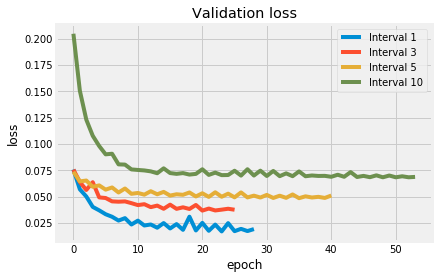

In [14]:
for i in prediction_intervals:
    plt.plot(model_history[i].history['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Interval 1', 'Interval 3', 'Interval 5', 'Interval 10'], loc='upper right')
plt.show()

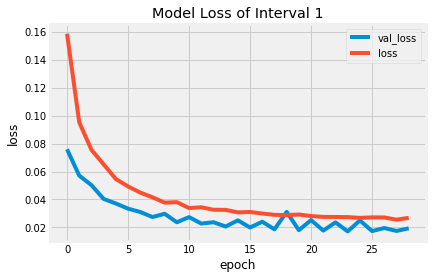

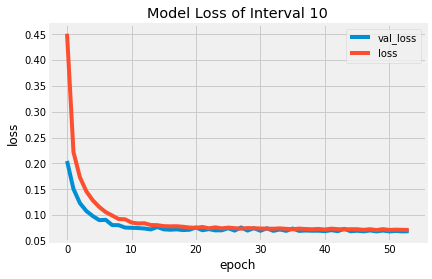

In [28]:
for i in [1,10]:
    plt.plot(model_history[i].history['val_loss'])
    plt.plot(model_history[i].history['loss'])
    plt.title('Model Loss of Interval {}'.format(i))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'loss'], loc='upper right')
    plt.show()

In [15]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [16]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

In [17]:
def make_test_data(s):
    scaler = {s:{}}
    test_set = {s:{}}
    test_set.update({s:{
            'x_1':{},
            'y':{},
        }})
    for i in prediction_intervals:
            test_set[s]['x_1'][i] = []
            test_set[s]['y'][i] = []
            scaler[s][i] = []

    data_1 = testSet.loc[testSet['ticker'] == s][['adj_close']].values
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)

    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    scaler[s][j].append(sc)
                    
                    test_set[s]['x_1'][j].append(sc.transform(x_1))
                    test_set[s]['y'][j].append(y)
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True
                    
    return test_set, scaler

In [18]:
def make_prediction(data, s, scaler):
    mse_val = {}
    y_true_val = {}
    y_pred_val = {}
    
    for i in prediction_intervals:
        x_test = []
        for j in range (0, len(data[s]['x_1'][i])):
            x = [
                data[s]['x_1'][i][j],
            ]
            x_test.append(x)

        X_test = np.array(x_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
        
        result = model[i].predict(X_test)
        
        y_pred = []
        for j in range(0,len(result)):
            y = result[j]
            y = y.reshape(-1,1)
            k = scaler[s][i][j].inverse_transform(y)
            y_pred.append(k[0][0])
                    
        y_test = data[s]['y'][i]
        y_true = np.array(y_test)
        y_true = y_true.reshape(y_true.shape[0])
    
        y_true_val[i] = y_true
        y_pred_val[i] = y_pred

        mse_val[i] = return_mse(y_true, y_pred) 
    return y_true_val, y_pred_val, mse_val

In [19]:
s = 'AAPL'
data, sc = make_test_data(s)
y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)

for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of AAPL inveral 1: 12.889368736911017
Test Set -> MSE of AAPL inveral 3: 30.412771233734528
Test Set -> MSE of AAPL inveral 5: 46.11787871098424
Test Set -> MSE of AAPL inveral 10: 76.0303804672963


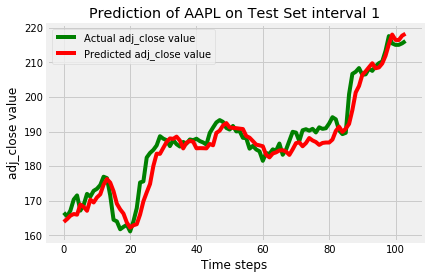

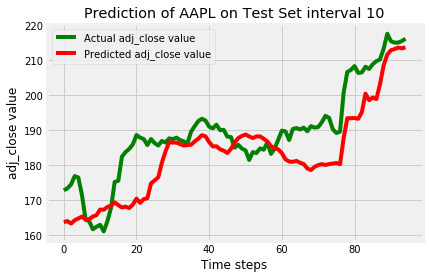

In [20]:
for i in [1,10]:
    plotting_graph(y_true_val[i], y_pred_val[i], s, 'Test Set interval {}'.format(i))

# MSE of 5 symbols

In [21]:
test_symbols = ['A','AAPL','ABAX','ACIU','ADUS']

In [22]:
all_mse = {}
for s in test_symbols:
    all_mse[s] = {}
    data, sc = make_test_data(s)
    y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)
    for i in prediction_intervals:
        all_mse[s][i] = mse_val[i]
        all_mse[s][i] = mse_val[i]

In [23]:
all_mse_1 = []
all_mse_10 = []
for s in all_mse:
    all_mse_1.append(round(all_mse[s][1], 3))
    all_mse_10.append(round(all_mse[s][10], 3))

In [24]:
all_mse_1

[1.535, 12.889, 5.943, 1.468, 2.615]

In [25]:
all_mse_10

[4.079, 76.03, 30.642, 6.361, 16.171]

In [26]:
for i in range(0, len(all_mse_1)):
    print('MSE of Interval 10 = {} Interval 1'.format(round(all_mse_10[i]/all_mse_1[i], 1)))

MSE of Interval 10 = 2.7 Interval 1
MSE of Interval 10 = 5.9 Interval 1
MSE of Interval 10 = 5.2 Interval 1
MSE of Interval 10 = 4.3 Interval 1
MSE of Interval 10 = 6.2 Interval 1
